<a href="https://colab.research.google.com/github/poffertje/TextMining/blob/master/code/topic_modelling/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/Shareddrives/Minecraft/Datasets')

In [3]:
import pandas as pd
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
from pprint import pprint
from gensim.models import CoherenceModel
import numpy as np
from matplotlib.pyplot import figure
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')
#! pip install pyLDAvis
#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Data preprocessing

In [5]:
yelp_100k = pd.read_csv('8April_100k_sentiment_sample_50_50_mixed.csv')
coher = pd.read_csv('new_lda_tuning_results.csv')

In [6]:
stemmer = nltk.stem.SnowballStemmer('english')
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [7]:
without_rest = yelp_100k[yelp_100k['productID'] != 1814]
without_rest.dropna(inplace=True)
processed_docs = without_rest['review'].map(preprocess)


In [8]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 actually
1 afterparty
2 amaze
3 attitude
4 bayonne
5 breakfast
6 broadway
7 brownstone
8 buttermilk
9 city
10 credit


In [9]:
#Filter out tokens that appear in less than 15 documents or more than 0.5 documents (fraction of total corpus size). Also, keep only the first 100000 most frequent tokens.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)


In [10]:
dictionary.save_as_text("dict_100kv3")

In [11]:
#For each document we create a dictionary reporting how many words and how many times those words appear.
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
#bow_corpus1 = [dictionary.doc2bow(doc) for doc in proc]


In [12]:
#Create tf-idf model object using models.
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.08120242403039891),
 (1, 0.06444943139236754),
 (2, 0.1227401872389984),
 (3, 0.2022520986808012),
 (4, 0.09963195590312544),
 (5, 0.35421791264081776),
 (6, 0.2492909752559514),
 (7, 0.16382026023608712),
 (8, 0.08628781775620206),
 (9, 0.1268750263449138),
 (10, 0.2411458803788603),
 (11, 0.11690188141293452),
 (12, 0.13782219195525885),
 (13, 0.20334821625303842),
 (14, 0.15255640554883582),
 (15, 0.05732573504277782),
 (16, 0.125294251524681),
 (17, 0.10243192674922533),
 (18, 0.0999104293020434),
 (19, 0.07718108460805749),
 (20, 0.020219500922107045),
 (21, 0.05930854332051714),
 (22, 0.04195623943390984),
 (23, 0.033910071293356756),
 (24, 0.12591601104996264),
 (25, 0.08988248279983829),
 (26, 0.14093234827751994),
 (27, 0.11073216083310913),
 (28, 0.24878560986722195),
 (29, 0.08467082649577783),
 (30, 0.14020439446875504),
 (31, 0.05287961582460069),
 (32, 0.22911459022768327),
 (33, 0.0583319859974731),
 (34, 0.14846766722946578),
 (35, 0.022586632327902673),
 (36, 0.

## Hyperparameter tuning

In [13]:
from gensim.models import CoherenceModel
import numpy as np
# supporting function
def compute_coherence_values(corpus, dictionary, k,):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           passes=2
                                           )
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()


In [15]:
#Grid Search for best params

import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 10
max_topics = 31
step_size = 10
topics_range = range(min_topics, max_topics, step_size)


# Validation sets
#num_of_docs = len(bow_corpus)
corpus_sets = [corpus_tfidf, bow_corpus]
corpus_title = ['TF-IDF', 'Bag of Words']
model_results = {'Corpus_Type': [],
                 'Topics': [],
                 'Coherence': []
                }
# Can take a long time to run
    # iterate through validation corpuses
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        # get the coherence score for the given parameters
        cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k)
        # Save the model results
        model_results['Corpus_Type'].append(corpus_title[i])
        model_results['Topics'].append(k)
        #model_results['Alpha'].append(a)
        #model_results['Beta'].append(b)
        model_results['Coherence'].append(cv)
                
        
pd.DataFrame(model_results).to_csv('new_new_lda_tuning_results.csv', index=False)

## Load best models

In [ ]:
# LDA with bag of words
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=14, id2word=dictionary, passes=2, workers=4)
lda_model.save("lda_modelv2")

NameError: ignored

In [ ]:
for idx, topic in lda_model.print_topics(-1):
 print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.025*"place" + 0.012*"coffee" + 0.012*"like" + 0.010*"good" + 0.009*"best" + 0.009*"love" + 0.008*"fresh" + 0.008*"ramen" + 0.007*"great" + 0.007*"breakfast"
Topic: 1 
Words: 0.023*"place" + 0.022*"order" + 0.016*"time" + 0.016*"good" + 0.016*"chicken" + 0.012*"thai" + 0.012*"great" + 0.011*"like" + 0.011*"soup" + 0.010*"love"
Topic: 2 
Words: 0.024*"great" + 0.022*"place" + 0.022*"like" + 0.014*"drink" + 0.011*"service" + 0.011*"menu" + 0.010*"dinner" + 0.009*"night" + 0.009*"come" + 0.009*"go"
Topic: 3 
Words: 0.019*"great" + 0.018*"good" + 0.012*"place" + 0.010*"cheese" + 0.010*"delicious" + 0.010*"sandwich" + 0.009*"like" + 0.007*"come" + 0.007*"salad" + 0.007*"fresh"
Topic: 4 
Words: 0.017*"dish" + 0.015*"good" + 0.013*"restaurant" + 0.012*"order" + 0.012*"come" + 0.008*"time" + 0.008*"like" + 0.008*"service" + 0.007*"dessert" + 0.007*"go"
Topic: 5 
Words: 0.019*"best" + 0.019*"pizza" + 0.014*"love" + 0.013*"place" + 0.010*"time" + 0.009*"like" + 0.008*"go" + 0.0

In [ ]:
#Running LDA using TF-IDF (best model)
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=12, id2word=dictionary, passes=2, workers=4)
lda_model_tfidf.save("new_lda_model_tfidf")
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.016*"great" + 0.011*"food" + 0.009*"good" + 0.009*"service" + 0.008*"price" + 0.008*"place" + 0.007*"love" + 0.007*"atmosphere" + 0.007*"friendly" + 0.006*"staff"
Topic: 1 Word: 0.009*"chicken" + 0.007*"sauce" + 0.007*"thai" + 0.007*"rice" + 0.007*"curry" + 0.006*"sandwich" + 0.005*"cart" + 0.005*"banh" + 0.004*"spicy" + 0.004*"fry"
Topic: 2 Word: 0.011*"sandwich" + 0.010*"falafel" + 0.010*"cheesesteak" + 0.009*"philly" + 0.008*"geno" + 0.007*"steak" + 0.006*"crepe" + 0.006*"cheese" + 0.005*"best" + 0.004*"line"
Topic: 3 Word: 0.004*"great" + 0.004*"delicious" + 0.004*"cheese" + 0.004*"good" + 0.004*"tacos" + 0.004*"sauce" + 0.003*"love" + 0.003*"order" + 0.003*"place" + 0.003*"amaze"
Topic: 4 Word: 0.005*"table" + 0.005*"wait" + 0.005*"time" + 0.005*"food" + 0.004*"order" + 0.004*"service" + 0.004*"drink" + 0.004*"come" + 0.004*"go" + 0.004*"place"
Topic: 5 Word: 0.032*"pizza" + 0.007*"slice" + 0.007*"crust" + 0.006*"best" + 0.005*"place" + 0.004*"wait" + 0.004*"great

## **Evaluation**

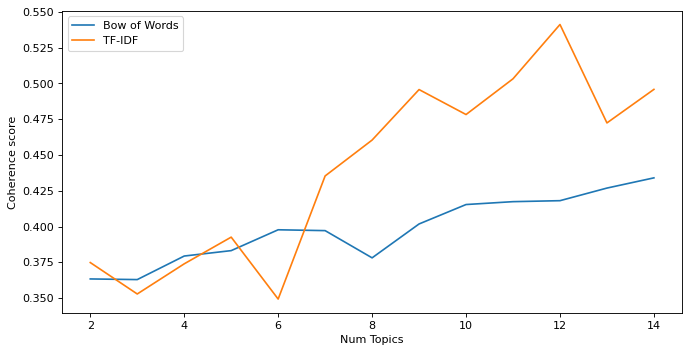

In [ ]:
#coherence plot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 5), dpi=80)
coherence_bow = coher[coher['Corpus_Type'] != "TF-IDF"]
topic_n = coherence_bow["Topics"]
coherence_tfidf = coher[coher['Corpus_Type'] == "TF-IDF"]
plt.plot(topic_n, coherence_bow["Coherence"], label = "Bow of Words")
plt.plot(topic_n, coherence_tfidf["Coherence"], label = "TF-IDF")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.show()

In [ ]:
%matplotlib inline
#! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis = gensimvis.prepare(topic_model=lda_model, corpus=bow_corpus, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
